### Generating Images with VAEs and GANs





### Vartional Auto Encoder (VAE)
- A VAE model optimizes the Evidence Lower Bound (ELBO) as follows:
<center> $P(x) \geq E_{q_{\theta}(z|x)}[q_{\phi}(x|z)] + D_{KL}\left(q_{\theta}\left(z|x\right)|| p\left(z\right)\right)$ </center>
where $q_{\theta}, q_{\phi}$ are instantiated as encoder and decoder, respectively. $p(z)$ is the prior distribution, which is usually chosen as Normal distribution $\mathcal{N}(0,1)$


In [ ]:
"""
Import PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
"""
Enable CUDA if the GPU is available
"""
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Ankle Boot


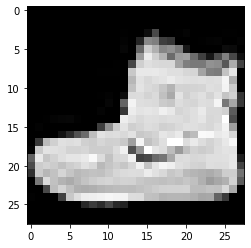

In [ ]:
"""
Define the dataloader for the Fashion MNIST dataset.
"""
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

#### VAE Model

In [ ]:
"""
A Convolutional Variational Autoencoder
"""
class vae(nn.Module):
    def __init__(self):
        super(vae, self).__init__()

        # layers for encoding subnetwork
        self.encoder = nn.Sequential(nn.Conv2d(1, 4, 5),
                                     nn.ReLU(),
                                     nn.Conv2d(4, 8, 5),
                                     nn.ReLU(),
                                     nn.Conv2d(8, 16, 5),
                                     nn.ReLU(),
                                     nn.Conv2d(16, 32, 5),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, 5),
                                     nn.ReLU(),
                                     nn.Conv2d(64, 128, 5),
                                     nn.ReLU(),
                                     nn.Conv2d(128, 256, 4),
                                     nn.ReLU())


        self.encoder_mean = nn.Linear(256, 128)
        self.encoder_var  = nn.Linear(256, 128)

        # layers for decoding subnetwork
        self.decoder_lin = nn.Linear(128, 256)
        self.decoder = nn.Sequential(nn.ReLU(),
                                     nn.ConvTranspose2d(256, 128, 4),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(128, 64, 5),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(64, 32, 5),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 16, 5),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(16, 8, 5),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(8, 4, 5),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(4, 1, 5),
                                     nn.Sigmoid())

    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1, 256)
        return self.encoder_mean(encoded), self.encoder_var(encoded)

    def reparameterize(self, mean, var):
        std     = torch.exp(var/2)
        epsilon = torch.randn_like(std)
        return mean + std * epsilon

    def decode(self, z):
        x_ = self.decoder_lin(z)
        x_ = x_.view(-1, 256, 1, 1)
        return self.decoder(x_)

    def forward(self, x):
        mean, var = self.encode(x)
        z = self.reparameterize(mean, var)
        return self.decode(z), mean, var

#### Training Loop


In [ ]:
"""
Initialize Hyperparameters
"""
batch_size = 128
learning_rate = 1e-3
num_epochs = 20

"""
Initialize the network and the Adam optimizer
"""
VAE = vae().to(device)
opt = torch.optim.Adam(VAE.parameters(), learning_rate)
# loss_func = nn.BCELoss()

"""
Training the network for a given number of epochs
"""
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        input = data[0].to(device)

        output, mean, var = VAE(input)
        kl = 0.5 * torch.sum(-1 - var + mean.pow(2) + var.exp())
        loss = F.binary_cross_entropy(output, input, size_average=False) + kl

        opt.zero_grad()
        loss.backward()
        opt.step()
        if i % 300 == 0 or i == len(train_loader):
            print('Epoch {} Iteration {}: Loss {:.3f}'.format(epoch, i, loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 Iteration 0: Loss 57292.875
Epoch 0 Iteration 300: Loss 30563.762
Epoch 1 Iteration 0: Loss 28966.469
Epoch 1 Iteration 300: Loss 26267.430
Epoch 2 Iteration 0: Loss 26492.461
Epoch 2 Iteration 300: Loss 25188.936
Epoch 3 Iteration 0: Loss 25778.080
Epoch 3 Iteration 300: Loss 24761.525
Epoch 4 Iteration 0: Loss 25126.537
Epoch 4 Iteration 300: Loss 24384.158
Epoch 5 Iteration 0: Loss 24963.037
Epoch 5 Iteration 300: Loss 24134.920
Epoch 6 Iteration 0: Loss 24884.764
Epoch 6 Iteration 300: Loss 24205.311
Epoch 7 Iteration 0: Loss 24619.586
Epoch 7 Iteration 300: Loss 23909.232
Epoch 8 Iteration 0: Loss 24464.498
Epoch 8 Iteration 300: Loss 23829.811
Epoch 9 Iteration 0: Loss 24481.930
Epoch 9 Iteration 300: Loss 23737.406
Epoch 10 Iteration 0: Loss 24303.295
Epoch 10 Iteration 300: Loss 23685.230
Epoch 11 Iteration 0: Loss 24510.162
Epoch 11 Iteration 300: Loss 23548.162
Epoch 12 Iteration 0: Loss 24182.668
Epoch 12 Iteration 300: Loss 23524.967
Epoch 13 Iteration 0: Loss 24268

#### Visualizing the output

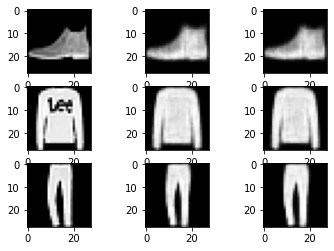

In [ ]:

"""
The following part takes two images from test loader to feed into the VAE.
Both the original image and generated image(s) from the distribution are shown.
"""

import matplotlib.pyplot as plt
import numpy as np

VAE.eval()
with torch.no_grad():
    imgs, _ = list(test_loader)[0]
    imgs = imgs.to(device)
    fig, ax = plt.subplots(3,3)
    ax = ax.reshape(-1)
    for i in range(3):
      for j in range(3):
        if j == 0:
          # input image
          img = np.transpose(imgs[i].cpu().numpy(), [1,2,0])
          ax[i*3+j].imshow(np.squeeze(img), cmap = 'gray')
        else:
          # vae generation results
          out, mu, logVAR = VAE(imgs)
          outimg = np.transpose(out[i].cpu().numpy(), [1,2,0])
          ax[i*3+j].imshow(np.squeeze(outimg), cmap = 'gray')
    plt.show()
